# Multiple Clustering, Part I

As there are many methods that exist for clustering, I thought it might be worth creating a class called "Clusters" that holds the most common algorithms with their correct 

## Necessary Libraries

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import numpy as np
import pickle
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn import metrics 
from scipy.spatial.distance import cdist  
from sklearn.preprocessing import normalize

In [121]:
class Cluster:
    def __init__(self,X,labels):
        self.X = X
        self.labels = labels
    
    def save(self,path):
        with open (path,"wb") as f:
            pickle.dump(self.model,f)
            
            
class K_Mean_Clustering(Cluster):
    def __init__(self,X,labels):
        super().__init__(X,labels)
        self.model = None
        self.n_clusters = None
        
    def FitModel(self,n_clusters = 2, n_init = 12):
        k_means = KMeans(init = "k-means++", n_clusters = n_clusters, n_init = n_init)
        self.n_clusters = n_clusters
        self.model = k_means.fit(self.X)
    
    def plot(self,x_axis=0,y_axis=1):
        fig = plt.figure(figsize=(6,4))
        colors = plt.cm.Spectral(np.linspace(0,1,len(set(self.model.labels_))))
        ax = fig.add_subplot(1,1,1)
        for k,col in zip(range(self.n_clusters),colors):
            my_clusters = (self.model.labels_ == k) 
            cluster_center = self.model.cluster_centers_[k]
            ax.plot(self.X[my_clusters, x_axis], self.X[my_clusters, y_axis], 'w', markerfacecolor=col, marker='.')
            ax.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)
        ax.set_title('KMeans, {} clusters'.format(self.n_clusters))
        ax.set_xlabel(self.labels[x_axis])
        ax.set_ylabel(self.labels[y_axis])
        ax.set_xticks(())
        ax.set_yticks(())
        plt.show()
        
    def evaluate(self):
        distortions = []
        inertias = []
        K = []
        for k in range(1,11):
            K_mean = KMeans(n_clusters = k, n_init = 12).fit(self.X)
            distortions.append(sum(np.min(cdist(self.X, K_mean.cluster_centers_,'euclidean'),axis=1))\
                               / self.X.shape[0])
            inertias.append(K_mean.inertia_) 
            K.append(k)
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)

        ax.plot(K,distortions/ np.linalg.norm(distortions))
        ax.plot(K,inertias/ np.linalg.norm(inertias))
        ax.set_xticks(K)
        plt.legend(labels = ['distortions','inertias'])
        plt.show()
        
        
            


        

## Testing on walking Data
Source: https://github.com/mmalekzadeh/motion-sense

In [3]:
path = '~/KinKeepers/ProjectAI/Data/sub_1.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,0,-1.711140,-1.429168,-2.591433,-0.139767,0.989987,0.019745,-0.350593,-0.511691,-0.865217,0.091702,0.415881,0.093689
1,1,-1.787917,-1.414171,-2.630956,-0.152324,0.987759,0.033602,-0.550553,-2.243217,-0.582409,0.367412,0.004566,-0.106082
2,2,-1.897323,-1.399331,-2.706668,-0.161610,0.985336,0.054729,-0.931014,-1.358033,-0.503947,0.172093,-0.217483,-0.163387
3,3,-2.018375,-1.383279,-2.813421,-0.168058,0.982470,0.080680,-1.304668,-0.541368,-0.346302,0.004957,-0.237566,-0.019080
4,4,-2.124395,-1.364054,-2.913092,-0.174613,0.978705,0.107922,-1.278349,-0.434722,-0.398598,-0.040292,-0.241461,0.015201


## Data Cleaning

In [4]:
df = df[df.columns[-6:]]
df.head()

,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.350593,-0.511691,-0.865217,0.091702,0.415881,0.093689
1,-0.550553,-2.243217,-0.582409,0.367412,0.004566,-0.106082
2,-0.931014,-1.358033,-0.503947,0.172093,-0.217483,-0.163387
3,-1.304668,-0.541368,-0.346302,0.004957,-0.237566,-0.019080
4,-1.278349,-0.434722,-0.398598,-0.040292,-0.241461,0.015201


In [5]:
#let a_i define acceleration in basis i, omega_i rotation around axis i
new_labels = ['omega_x','omega_y','omega_z','a_x','a_y','a_z']
df.columns = new_labels
df.head()

,omega_x,omega_y,omega_z,a_x,a_y,a_z
0,-0.350593,-0.511691,-0.865217,0.091702,0.415881,0.093689
1,-0.550553,-2.243217,-0.582409,0.367412,0.004566,-0.106082
2,-0.931014,-1.358033,-0.503947,0.172093,-0.217483,-0.163387
3,-1.304668,-0.541368,-0.346302,0.004957,-0.237566,-0.019080
4,-1.278349,-0.434722,-0.398598,-0.040292,-0.241461,0.015201


In [6]:
df.shape
#large data set, this is good :)

(5439, 6)

In [7]:
#let's combine the accelerations and gyrations in magnitudes of each respective vector
#let A and Omega represent magnitude
df['Omega'] = np.power(df[new_labels[0:3]],2).sum(axis = 1)
df['A'] = np.power(df[new_labels[3:]],2).sum(axis =1)
df.drop(new_labels, axis =1,inplace = True)
df.head()

,Omega,A
0,1.133344,0.190144
1,5.674331,0.146266
2,2.965003,0.103610
3,2.115163,0.056826
4,1.982040,0.060158


## Data visualisation

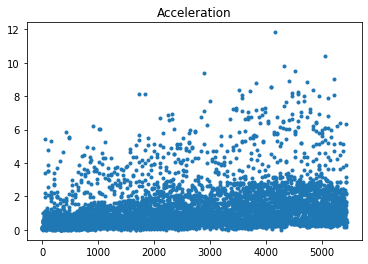

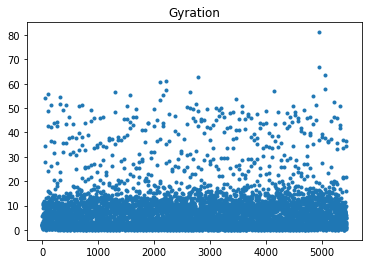

In [8]:
#for the sake of visualising what you are doing:

plt.plot(df.index,df.A,'.')
plt.title("Acceleration")
plt.show()

plt.plot(df.index,df.Omega,'.')
plt.title("Gyration")
plt.show()

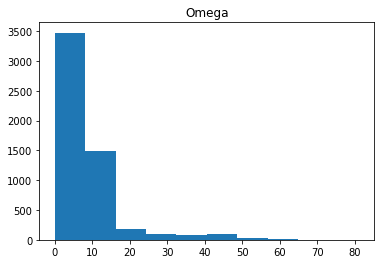

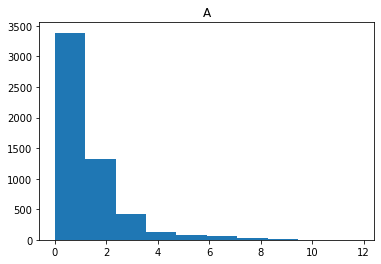

In [9]:
#the data sets look terrible, let's see their distributions and if we can clean them out at all?
for i in range(2):
    plt.hist(df[df.columns[i]])
    plt.title(df.columns[i])
    plt.show()


## Data De-Skewing

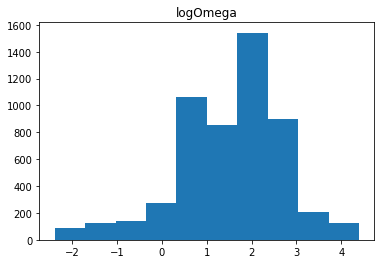

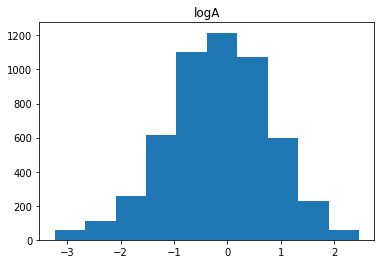

In [45]:
# we need to de-skew the data, let's perform a log transform
df_log = df.copy()
df_log = np.log(df_log)
df_log.columns = ['log{}'.format(i) for i in df_log.columns]


for i in range(2):
    plt.hist(df_log[df_log.columns[i]])
    plt.title(df_log.columns[i])
    plt.show()

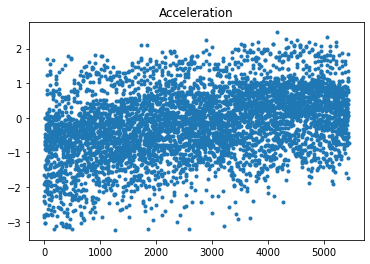

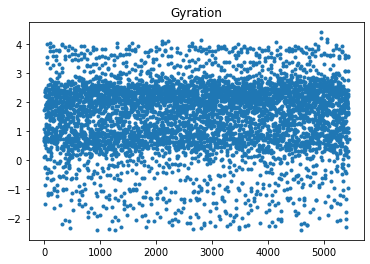

In [46]:
plt.plot(df_log.index,df_log.logA,'.')
plt.title("Acceleration")
plt.show()

plt.plot(df_log.index,df_log.logOmega,'.')
plt.title("Gyration")
plt.show()

## Removing outliers

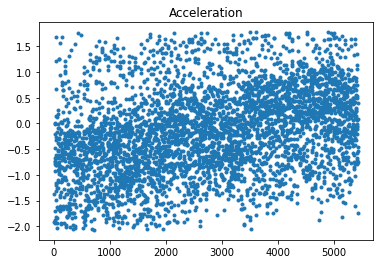

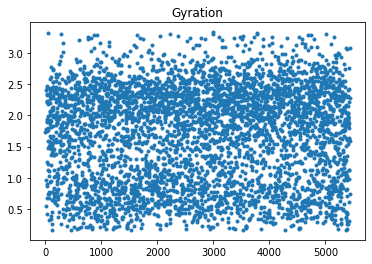

In [47]:
#now that the transformation is less skewed, it's worth removing outliers
""" Note on outlier removal: this assuming a normal distribtion which is invalid. Removing outliers based on the 
upper and lower quartiles seems smarter, see next cell for proof"""
median = [df_log.quantile(0.5)][0]

lower, upper = [df_log.logA.quantile(0.25), df_log.logOmega.quantile(0.25)],[df_log.logA.quantile(0.75), df_log.logOmega.quantile(0.75)]
iqr = [u - l for u,l in zip(upper,lower)]
columns = df_log.columns


for i in range(2):
    df_log = df_log[(df_log[columns[i]]>median[i]-1.25*iqr[i])]
    
for i in range(2):
    df_log = df_log[(df_log[columns[i]]<median[i]+1.25*iqr[i])]

plt.plot(df_log.index,df_log.logA,'.')
plt.title("Acceleration")
plt.show()

plt.plot(df_log.index,df_log.logOmega,'.')
plt.title("Gyration")
plt.show()


#the data does look much better, but I'm still unsure if it's good enough...

Text(0, 0.5, 'logA')

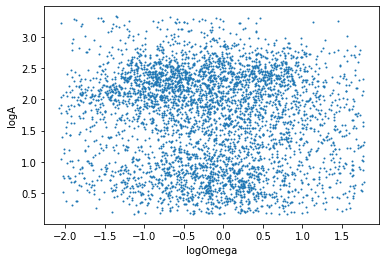

In [52]:
#data sets still look terrible...
#let's try to sketch them on a scatter plot

plt.scatter(x = df_log.logA, y = df_log.logOmega, s= 1 )
plt.xlabel(df_log.columns[0])
plt.ylabel(df_log.columns[1])

#note, here it seems that there are 'two' clusters, as we wanted. However, it's in a log form... 
#what does this mean?
#that if logA > ~1.4 for any omega, then you have two different types of motion?

Text(0, 0.5, 'A')

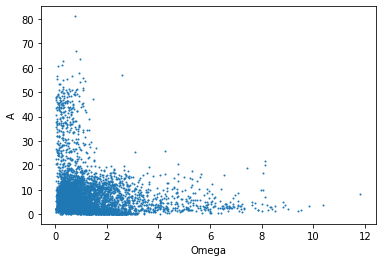

In [49]:
# for the sake of comparison

plt.scatter(x = df.A, y = df.Omega, s= 1 )
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])

In [50]:
#revert data to non-log form before performing K-means clustering
df = np.exp(df_log)
df.columns = ['Omega','A']
df.head()

,Omega,A
1,5.674331,0.146266
12,1.713523,0.254308
18,2.632455,0.472014
19,5.965400,0.510624
20,11.108648,0.457248


## Standardise Data

In [61]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler()
X_scaled.fit(np.asarray(df))
X_scaled = X_scaled.transform(np.asarray(df))
X_scaled

array([[0.16677618, 0.00351456],
       [0.01995175, 0.02220195],
       [0.05401595, 0.05985725],
       ...,
       [0.31645838, 0.16745328],
       [0.13847072, 0.07886248],
       [0.03370051, 0.06064693]])

## Model using K_means

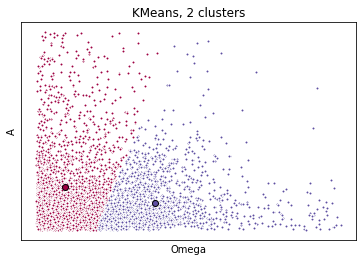

In [122]:
#once again, the data does not seem to add any insightful information...
#should we try to cluster the data anyways?
K_means = K_Mean_Clustering(X_scaled,df.columns)
K_means.FitModel()
K_means.plot()

the outcome is somewhat interesting... it seems to suggest that after a certain value general rotation
the datasets split. It does not seem to consider acceleration at all though...
the purple dataset is movements that involve a somewhat large amount of rotation, but with minimal acceleration?
this type of data is difficult to interpret... we should experiment with other classifiers to see if we can get any insights.


## Evaluate KMeans

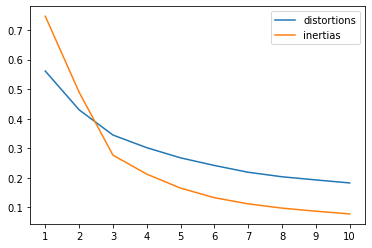

In [123]:
K_means.evaluate()

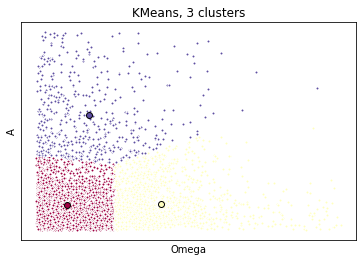

In [128]:
#let's actually view the model for k = 3
K_means.FitModel(3)
K_means.plot()
#this does not seem great, seems  like the K_means is actually limiting the quality od the clustering
#however, if you think about it, in a way it's better than the k=2 model, because it seems to create 3 classes:
#1) the 'noise' data which has very little omega and little A
#2) the high acceleration data with little turning
#3) the high gyration data with little acceleration

#my question would be: what actually is the high gyration data? I can't seem to think of movements that lead to high
#gyration...
#could it actually be that gyration is extremely noisy, and thus should perhaps be neglected entirely? Surely not eh?

#let's save the model with the current conditions
K_means.save('K_means_k_3.pkl')

# Conclusion

Created a class for clustering, with a subclass for K_means. Said subclass includes a plotting function, an evaluation function and a fitting function.

The next part of this project would be to add subclasses for other different clustering algorithms... 